In [5]:
pip install mne

  Using cached mne-1.9.0-py3-none-any.whl.metadata (20 kB)
  Using cached jinja2-3.1.6-py3-none-any.whl.metadata (2.9 kB)
  Using cached lazy_loader-0.4-py3-none-any.whl.metadata (7.6 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.0 kB)
Using cached mne-1.9.0-py3-none-any.whl (7.4 MB)
Using cached lazy_loader-0.4-py3-none-any.whl (12 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
Using cached jinja2-3.1.6-py3-none-any.whl (134 kB)
Using cached MarkupSafe-3.0.2-cp312-cp312-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (23 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [mne]4/5 [mne]a2]
Note: you may need to restart the kernel to use updated packages.


In [6]:
import mne
print(f"MNE-Python version: {mne.__version__}")

MNE-Python version: 1.9.0


In [7]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import mne
from mne.filter import filter_data, notch_filter
from scipy.signal import welch

Creating RawArray with float64 data, n_channels=8, n_times=2500
    Range : 0 ... 2499 =      0.000 ...     4.998 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 3301 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 4 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 0.50

/tmp/ipykernel_50955/784448537.py:28: RuntimeWarning: filter_length (3301) is longer than the signal (2500), distortion is likely. Reduce filter length or filter a longer signal.
  raw.notch_filter(np.array([50]))  # Sólo 50 Hz
/tmp/ipykernel_50955/784448537.py:40: RuntimeWarning: filter_length (6600) is longer than the signal (2500), distortion is likely. Reduce filter length or filter a longer signal.
  filtered[band] = raw.copy().filter(


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 13 - 30 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 13.00
- Lower transition bandwidth: 3.25 Hz (-12 dB cutoff frequency: 11.38 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 33.75 Hz)
- Filter length: 1016 samples (2.032 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 30 - 45 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hamming window
- Lower passband edge: 30.00
- Lower transition bandwidth: 7.50 Hz (-12 dB cutoff frequency: 26.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-12 dB cu

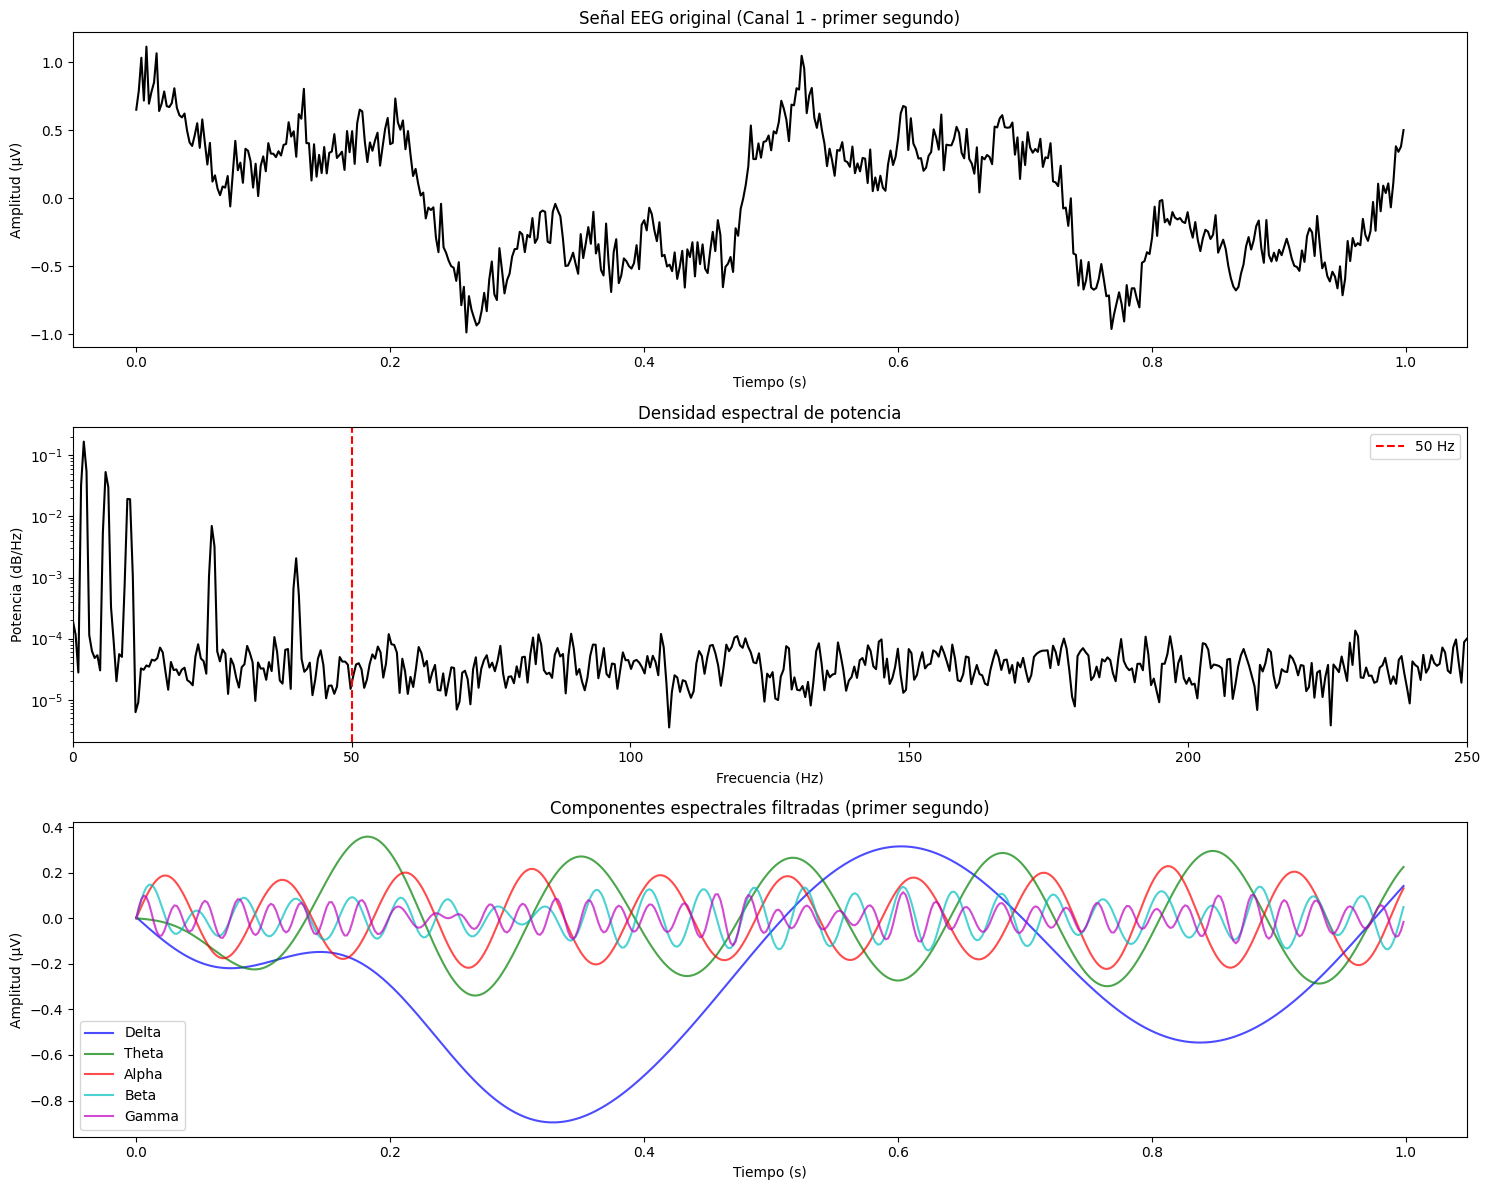

In [9]:
# Configuración con una frecuencia de muestreo más alta
sample_rate = 500  # Aumentado a 500 Hz para permitir el filtrado gamma
np.random.seed(42)

def simulate_eeg(duration=10, n_channels=8):
    n_samples = int(duration * sample_rate)
    time = np.linspace(0, duration, n_samples)

    # Componentes cerebrales con más variabilidad
    signals = [
        0.5 * np.sin(2 * np.pi * 2 * time + np.random.rand()),    # Delta
        0.3 * np.sin(2 * np.pi * 6 * time + np.random.rand()),    # Theta
        0.2 * np.sin(2 * np.pi * 10 * time + np.random.rand()),   # Alpha
        0.1 * np.sin(2 * np.pi * 25 * time + np.random.rand()),   # Beta
        0.05 * np.sin(2 * np.pi * 40 * time + np.random.rand())   # Gamma
    ]

    clean_eeg = sum(signals)
    noise = 0.1 * np.random.randn(n_samples, n_channels)
    eeg_data = clean_eeg[:, np.newaxis] + noise

    info = mne.create_info(n_channels, sample_rate, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data.T, info)
    return raw, time

def filter_eeg(raw):
    # Filtro notch solamente a 50 Hz (armónicos debajo de Nyquist)
    raw.notch_filter(np.array([50]))  # Sólo 50 Hz

    bands = {
        'Delta': (0.5, 4),
        'Theta': (4, 8),
        'Alpha': (8, 13),
        'Beta': (13, 30),
        'Gamma': (30, 45)  # Limitado a 45 Hz para mantenerse debajo de Nyquist
    }

    filtered = {}
    for band, (l_freq, h_freq) in bands.items():
        filtered[band] = raw.copy().filter(
            l_freq, h_freq,
            method='fir',
            fir_window='hamming',
            phase='zero-double',
            fir_design='firwin2'
        )

    return filtered

def plot_results(raw, filtered, time):
    plt.figure(figsize=(15, 12))

    # Señal original
    plt.subplot(3, 1, 1)
    plt.plot(time[:500], raw.get_data()[0, :500], 'k')  # Solo el primer segundo
    plt.title('Señal EEG original (Canal 1 - primer segundo)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (µV)')

    # Densidad espectral de potencia
    plt.subplot(3, 1, 2)
    f, Pxx = welch(raw.get_data()[0], fs=sample_rate, nperseg=1024)
    plt.semilogy(f, Pxx, 'k')
    plt.axvline(x=50, color='r', linestyle='--', label='50 Hz')
    plt.title('Densidad espectral de potencia')
    plt.xlabel('Frecuencia (Hz)')
    plt.ylabel('Potencia (dB/Hz)')
    plt.xlim(0, sample_rate/2)
    plt.legend()

    # Señales filtradas (primer segundo)
    plt.subplot(3, 1, 3)
    colors = {'Delta':'b', 'Theta':'g', 'Alpha':'r', 'Beta':'c', 'Gamma':'m'}
    for band, color in colors.items():
        data = filtered[band].get_data()[0, :500]
        plt.plot(time[:500], data, color, label=band, alpha=0.7)
    plt.title('Componentes espectrales filtradas (primer segundo)')
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Amplitud (µV)')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Ejecución
raw, time = simulate_eeg(duration=5)  # Duración reducida para la demostración
filtered = filter_eeg(raw)
plot_results(raw, filtered, time)
